**Now, why is the python version different from the sys.version?**: sys.version gives the IPy kernel version, `!python --version` gives the REPL python version from which Jupyter notebook starts

## Load data & packages

In [1]:
# enable python linting
%load_ext nb_black

# input dataset
input_file = "../data/all_combined_training.csv"
validation_file = "../data/all_combined_validation.csv"

dfName = "df1"
processed_data = lambda dfName: "../data/" + dfName + "_processed.csv"

model_root = "../artifacts/models/"
data_root = "../data/"
fig_root = "../figs/"
package_root = "../packages/"
root = "../"
DEBUG_MODE = True

<IPython.core.display.Javascript object>

In [2]:
%%capture
import os
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import numpy as np
import pandas as pd
import scipy.stats as scs

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import pickle
# joblib still saves model in .pickle files
from joblib import dump, load
import xgboost as xgb

sns.set()
plt.style.use('bmh')

# There is a slight chance that I might have to run the following two lines for the local package to work
# import sys
# sys.path.insert(0, '..')

import warnings
warnings.filterwarnings('ignore')

from PrepPred import prep
Preprocessing = prep.Preprocessing()

<IPython.core.display.Javascript object>

In [3]:
# # load data
# df = pd.read_csv(processed_data(dfName="df1"), index_col=0)
# df.sample(2)

<IPython.core.display.Javascript object>

## Hourly resolution

In [4]:
# list_of_df = Preprocessing.load_dframes(
#     df_name="df", prop="_processed", data_root=data_root
# )

# for i in range(0, 9):
#     vars()["df" + str(i + 1) + "_processed"] = list_of_df[i]

# # ensure
# Preprocessing.show_shape([df1_processed, df2_processed, df9_processed])

<IPython.core.display.Javascript object>

In [5]:
df_name = "df2_processed"

<IPython.core.display.Javascript object>

In [6]:
df = Preprocessing.load_n_sort(df=df_name, data_root=data_root)
df

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date,kw_cap,datetime
0,2013,1,1,0,849.450417,62.20071,-75.65,1483,1347.844242,-19.559714,2013-01-01,0.572792,2013-01-01 00:00:00
1,2013,1,1,1,891.025667,62.20071,-75.65,1483,1347.844242,-19.994040,2013-01-01,0.600826,2013-01-01 01:00:00
2,2013,1,1,2,905.738833,62.20071,-75.65,1483,1347.844242,-19.779135,2013-01-01,0.610748,2013-01-01 02:00:00
3,2013,1,1,3,847.466417,62.20071,-75.65,1483,1347.844242,-18.466940,2013-01-01,0.571454,2013-01-01 03:00:00
4,2013,1,1,4,823.321083,62.20071,-75.65,1483,1347.844242,-18.182593,2013-01-01,0.555173,2013-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,2015,12,31,19,1162.631500,62.20071,-75.65,1483,1347.844242,-20.950980,2015-12-31,0.783973,2015-12-31 19:00:00
26276,2015,12,31,20,1100.915667,62.20071,-75.65,1483,1347.844242,-21.188574,2015-12-31,0.742357,2015-12-31 20:00:00
26277,2015,12,31,21,1078.913333,62.20071,-75.65,1483,1347.844242,-21.051993,2015-12-31,0.727521,2015-12-31 21:00:00
26278,2015,12,31,22,1075.409083,62.20071,-75.65,1483,1347.844242,-21.075659,2015-12-31,0.725158,2015-12-31 22:00:00


<IPython.core.display.Javascript object>

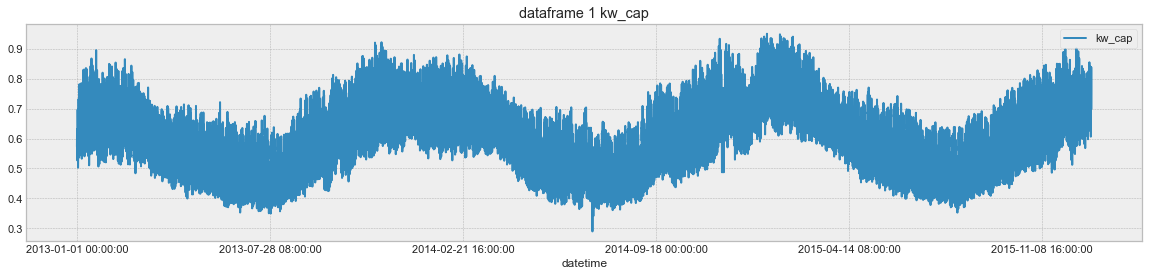

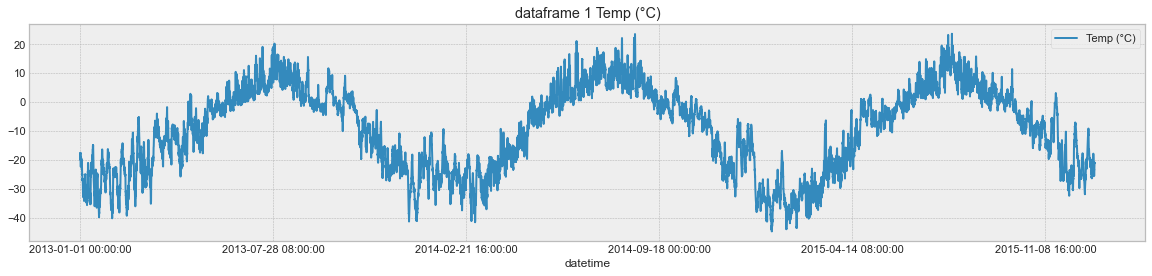

<IPython.core.display.Javascript object>

In [7]:
# plot_dfs() only plots kw_cap and temperature
Preprocessing.plot_dfs(dfs=[df], cols=["kw_cap", "Temp (°C)"])

## Scale and standardize the data

__The `temperature` and `kw_cap` seem *VERY* correlated__ once we plot them, but let's transform the two series before calculating the correlation. How about we scale them to `[0,1]`? 

In [8]:
# #  we scale kw_cap column to (0,1), and Temp column to range (0, 0.7)
# list_of_scaled_df = Preprocessing.scale_series(
#     list_of_df,
#     cols=["kw_cap", "Temp (°C)"],
#     cols_scaler_range=[(0, 1), (0, 0.7)],
#     DEBUG_MODE=False,
# )
# for i in range(len(list_of_scaled_df)):
#     vars()["df" + str(i + 1) + "_scaled"] = list_of_scaled_df[i]

# df6_scaled

<IPython.core.display.Javascript object>

In [9]:
# plt.figure(figsize=(18, 3))
# Preprocessing.plot_series(
#     range(len(df1_scaled.kw_cap)), df1_scaled.kw_cap, label="kw_cap_scaled"
# )
# Preprocessing.plot_series(
#     range(len(df1_scaled["Temp (°C)"])),
#     0.8 - df1_scaled["Temp (°C)"],
#     label=f"0.8 - temp_scaled",
# )

<IPython.core.display.Javascript object>

__Standardize the data__

In [10]:
# list_of_std_df = Preprocessing.standardize_series(
#     list_of_df[:3], cols=["kw_cap", "Temp (°C)"], DEBUG_MODE=True
# )

# # give the dataframe to designated vars
# for i in range(len(list_of_std_df)):
#     vars()["df" + str(i + 1) + "_stdard"] = list_of_std_df[i]

<IPython.core.display.Javascript object>

__Sanity check__: verify that the data mean and std are `0` and `1`

In [11]:
# dd = df2_stdard["kw_cap"].values.reshape(len(df2_stdard), 1)
# scaler = StandardScaler()
# scaler = scaler.fit(dd)
# print("Mean: %f, StandardDeviation: %f" % (scaler.mean_, sqrt(scaler.var_)))

<IPython.core.display.Javascript object>

## Let's find the correlation between two variables
* kw_cap ~ Temp
* kw_cap ~ year
* kw_cap ~ hour

Top 3 most correlated vars with  `kw_cap` are `Temp > hour > year`

In [20]:
# df1_processed[["kw_cap", "Temp (°C)", "year", "month", "day", "hour"]].corr(method="pearson")
df[["kw_cap", "Temp (°C)"]].corr(method="spearman")

,kw_cap,Temp (°C)
kw_cap,1.000000,-0.595335
Temp (°C),-0.595335,1.000000


<IPython.core.display.Javascript object>

### comparing with `pearson` or `kendall` correlation, `spearman` corr is the highest. It seems that there is some monotonic relationship between `Temp` and `kw_cap` but not necessarily linear. 

In [21]:
df[["kw_cap", "Temp (°C)"]].corr(method="pearson")

,kw_cap,Temp (°C)
kw_cap,1.000000,-0.589455
Temp (°C),-0.589455,1.000000


<IPython.core.display.Javascript object>

In [22]:
df[["kw_cap", "Temp (°C)"]].corr(method="kendall")

,kw_cap,Temp (°C)
kw_cap,1.000000,-0.407503
Temp (°C),-0.407503,1.000000


<IPython.core.display.Javascript object>

In [16]:
# df.corr()

<IPython.core.display.Javascript object>

__Correlation is the same regardless of the standardization, so we choose not to standardize__

In [14]:
# d_series = df1_stdard["kw_cap"]
# df1_processed["log_change"] = np.log(d_series / d_series.shift(1))
# Preprocessing.plot_QQ(df1_processed, "log_change")

<IPython.core.display.Javascript object>

In [15]:
# Preprocessing.plot_QQ(df1_stdard, "kw_cap")

<IPython.core.display.Javascript object>

### Scatter plot

In [37]:
# df1_stdard.plot(x="kw_cap", y="Temp (°C)", kind="scatter", figsize=(10, 5))
# # df1_processed.plot(x="kw_cap", y="hour", kind="scatter", figsize=(10, 5))
# # df1_processed.plot(x="kw_cap", y="year", kind="scatter", figsize=(10, 8))
# # df1_processed.plot(x="kw_cap", y="day", kind="scatter", figsize=(10, 8))
# # df1_processed.plot(x="kw_cap", y="annual_peak_load", kind="scatter", figsize=(10, 8))

<IPython.core.display.Javascript object>

__Notes on using exogenous data of past years to forecast Kw of future years:__

1. something doesn't quite make sense here in terms of the input and output data. 
    - First, if we use the exogenous data from `hour 1 of year 1` to predict the Kw  of `hour 1 of year 2`, based on what grounds do we know that after a WHOLE YEAR, the exogenous data can still accurately determine the power consumption? It's not like the Kw of `hour 1 of year2` is based on the `last 30 hours of year 1` (__which means it's in the immediate past with `window_size=30`__), it is a whole year in the past.
    - Second, even if we use the immediate past of `hour 1 of year 2` to predict the Kw of `hour 1 of year 2`, how are we supposed to predict `hour 2 of year 2`? Because to do so means we need the immediate past of `hour 2 of year 2`, which include the exogenous data of `hour 1 of year 2` (__that we should not have by setup__). 
    - The question at this point doesn't seem doable unless we magically find some analytical formula that maps the exogenous vars to Kw, for example, something like $y_{Kw}(t) = \alpha_1 X_{temp}(t-8760) +\alpha_2 X_{day-of-the-month}(t-8760)+\alpha_3 X_{population}(t-8760)+\dots$
2. A maybe approach is to use the exogenous data of year 1 to predict the Kw of year 1, then use Kw of year 1 to forecast the Kw of year 2. This would require using two different models on top of one another, can it be any good?

## Step 1: 
XGB Prediction of kw_cap using exogenous data of the same time period

In [17]:
# df.columns
# # df1_processed.hour.value_counts()

<IPython.core.display.Javascript object>

In [29]:
train_data = df[: int(df.shape[0] / 3)]
test_data = df[2 * int(df.shape[0] / 3) :]

drop_cols = [
    "kw_cap",
    "lat",
    "lon",
    "population",
    "annual_peak_load",
    "datetime",
    #     "log_change",
    "Kw",
    "date",
]
output_cols = ["kw_cap"]

X_train = train_data.copy().drop(columns=drop_cols)
X_test = test_data.copy().drop(columns=drop_cols)

y_train = train_data.copy()[output_cols]
y_test = test_data.copy()[output_cols]

<IPython.core.display.Javascript object>

__Just run once, the model is saved__

In [30]:
%%capture
xgb_r = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, seed=123)

xgb_r.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="mae",
)

xgb_r.save_model(model_root + "multivariate_xgb_regsr_" + df_name[:3] + ".json")

<IPython.core.display.Javascript object>

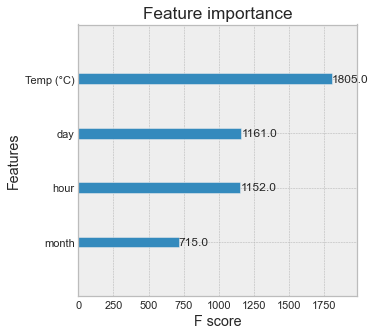

<IPython.core.display.Javascript object>

In [31]:
xgb_2 = xgb.XGBRegressor()
xgb_2.load_model(model_root + "multivariate_xgb_regsr_" + df_name[:3] + ".json")

xgb.plot_importance(xgb_2)
plt.rcParams["figure.figsize"] = [5, 5]
plt.show()

In [32]:
# X_train
# X_test
train_data

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date,kw_cap,datetime
0,2013,1,1,0,849.450417,62.20071,-75.65,1483,1347.844242,-19.559714,2013-01-01,0.572792,2013-01-01 00:00:00
1,2013,1,1,1,891.025667,62.20071,-75.65,1483,1347.844242,-19.994040,2013-01-01,0.600826,2013-01-01 01:00:00
2,2013,1,1,2,905.738833,62.20071,-75.65,1483,1347.844242,-19.779135,2013-01-01,0.610748,2013-01-01 02:00:00
3,2013,1,1,3,847.466417,62.20071,-75.65,1483,1347.844242,-18.466940,2013-01-01,0.571454,2013-01-01 03:00:00
4,2013,1,1,4,823.321083,62.20071,-75.65,1483,1347.844242,-18.182593,2013-01-01,0.555173,2013-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2013,12,31,19,1231.135500,62.20071,-75.65,1483,1347.844242,-31.845618,2013-12-31,0.830166,2013-12-31 19:00:00
8756,2013,12,31,20,1210.384583,62.20071,-75.65,1483,1347.844242,-31.837973,2013-12-31,0.816173,2013-12-31 20:00:00
8757,2013,12,31,21,1161.959667,62.20071,-75.65,1483,1347.844242,-31.606787,2013-12-31,0.783520,2013-12-31 21:00:00
8758,2013,12,31,22,1084.469000,62.20071,-75.65,1483,1347.844242,-32.661322,2013-12-31,0.731267,2013-12-31 22:00:00


<IPython.core.display.Javascript object>

In [33]:
# Predictions on the train dataset
train_pred = xgb_2.predict(X_train)
# RMSE Computation
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_pred = xgb_2.predict(X_test)
# RMSE Computation
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("Train RMSE : % f" % (train_rmse))
print("Test RMSE : % f" % (test_rmse))

Train RMSE :  0.014066
Test RMSE :  0.056546


<IPython.core.display.Javascript object>

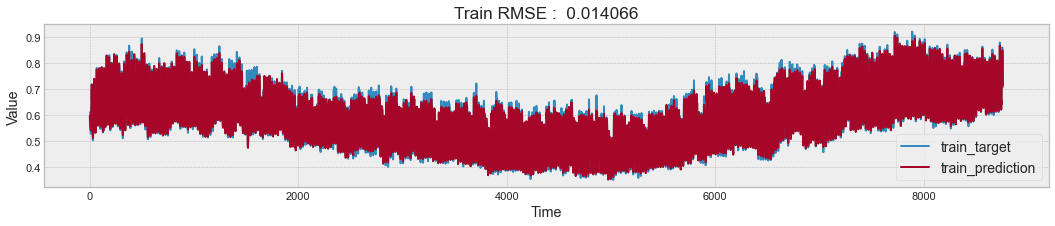

<IPython.core.display.Javascript object>

In [34]:
plt.figure(figsize=(18, 3))
target_s = pd.Series(y_train.kw_cap)[:]
pred_s = pd.Series(train_pred)[:]
plt.title("Train RMSE : % f" % (train_rmse))
Preprocessing.plot_series(range(len(target_s)), target_s, label="train_target")
Preprocessing.plot_series(range(len(pred_s)), pred_s, label=f"train_prediction")

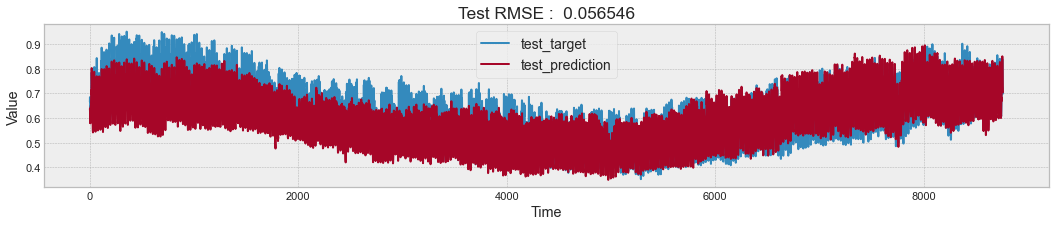

<IPython.core.display.Javascript object>

In [35]:
plt.figure(figsize=(18, 3))
target_s = pd.Series(y_test.kw_cap)[:]
pred_s = pd.Series(test_pred)[:]
plt.title("Test RMSE : % f" % (test_rmse))
Preprocessing.plot_series(range(len(target_s)), target_s, label="test_target")
Preprocessing.plot_series(range(len(pred_s)), pred_s, label=f"test_prediction")

In [38]:
pred_s

0       0.637436
1       0.632284
2       0.608280
3       0.590183
4       0.579207
          ...   
8755    0.810217
8756    0.788586
8757    0.762109
8758    0.732799
8759    0.704153
Length: 8760, dtype: float32

<IPython.core.display.Javascript object>

In [25]:
# X_train["Temp (°C) shift 1"] = X_train["Temp (°C)"].shift(
#     periods=1, fill_value=X_train["Temp (°C)"].mean()
# )
# X_train["Temp (°C) shift 3"] = X_train["Temp (°C)"].shift(
#     periods=3, fill_value=X_train["Temp (°C)"].mean()
# )
# X_train["Temp (°C) shift 5"] = X_train["Temp (°C)"].shift(
#     periods=5, fill_value=X_train["Temp (°C)"].mean()
# )
# X_train["Temp (°C) shift 7"] = X_train["Temp (°C)"].shift(
#     periods=7, fill_value=X_train["Temp (°C)"].mean()
# )

# X_test["Temp (°C) shift 1"] = X_test["Temp (°C)"].shift(
#     periods=1, fill_value=X_test["Temp (°C)"].mean()
# )
# X_test["Temp (°C) shift 3"] = X_test["Temp (°C)"].shift(
#     periods=3, fill_value=X_test["Temp (°C)"].mean()
# )
# X_test["Temp (°C) shift 5"] = X_test["Temp (°C)"].shift(
#     periods=5, fill_value=X_test["Temp (°C)"].mean()
# )
# X_test["Temp (°C) shift 7"] = X_test["Temp (°C)"].shift(
#     periods=7, fill_value=X_test["Temp (°C)"].mean()
# )

# X_test.head(2)
# # X_train.head(2)

<IPython.core.display.Javascript object>

In [26]:
# # %%capture
# xgb_r = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, seed=123)

# xgb_r.fit(
#     X_train,
#     y_train,
#     #     eval_set=[(X_train, y_train),(X_test, y_test)],
#     eval_metric="mae",
# )
# # Predictions on the train dataset
# train_pred = xgb_r.predict(X_train)
# # RMSE Computation
# train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
# test_pred = xgb_r.predict(X_test)
# # RMSE Computation
# test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
# print("Train RMSE : % f" % (train_rmse))
# print("Test RMSE : % f" % (test_rmse))

<IPython.core.display.Javascript object>

In [27]:
# plt.figure(figsize=(18, 3))
# target_s = pd.Series(y_train.kw_cap)[:]
# pred_s = pd.Series(train_pred)[:]
# plt.title("Train RMSE : % f" % (train_rmse))
# Preprocessing.plot_series(range(len(target_s)), target_s, label="train_target")
# Preprocessing.plot_series(range(len(pred_s)), pred_s, label=f"train_prediction")

<IPython.core.display.Javascript object>

In [28]:
# plt.figure(figsize=(18, 3))
# target_s = pd.Series(y_test.kw_cap)[:]
# pred_s = pd.Series(test_pred)[:]
# plt.title("Test RMSE : % f" % (test_rmse))
# Preprocessing.plot_series(range(len(target_s)), target_s, label="test_target")
# Preprocessing.plot_series(range(len(pred_s)), pred_s, label=f"test_prediction")

<IPython.core.display.Javascript object>